In [ ]:
import pandas as pd

import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

In [2]:
tblpath = "./tables/"
k = 1000000

---
# NEW


Fix:
 - columns `RelatedWorks` and `Provenance` have mixed data types (should both be str)  
     `pd.read_csv("v0.csv.gz", dtype=dict(Provenance="string", RelatedWorks="string"))`
     
 - get all data types right (`ObjectID` is saved/loaded as float)



# 1. Objects

In [3]:
id_fields = ["DepartmentID", "ClassificationID", "ObjectName", # this is the type of object
             "Medium", "Provenance", "Exhibitions"]
             
date_fields = ["BeginISODate", "EndISODate", "Dated"]

txt_fields = ["Title", "Description", "Notes", "CuratorialRemarks", "RelatedWorks", "HistAttributions"]

relevant_fields = id_fields + date_fields + txt_fields

objs = pd.read_csv(tblpath + f"Objects_{k}.csv.gz").set_index("ObjectID")[relevant_fields]

/home/valentin/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,3,4,8,9,10,11,15,17,18,19,20,21,22,24,25,26,27,29,31,32,34,38,39,42,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,67,68,69,71,79,80) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2. Dates

TODO:

 - get rid of objects with `BeginISODate == EndISODate == 0` -> 372k out of 1M
 - what about objects with `BeginISODate > EndISODate`?  --> remove, 4k out of 1M
 - replace objects whose `Dated == [NI]` with `"{BeginISODate} -- {EndISOdate}"` (or `"voor {EndISODate}"` if `BeginISODate == 0` and same with `"na {BeginISODate}"`) -> 190k out of 1M
 - objects which have dates > 2021 -> 2k out of 1M  
   => remove, since all of these are > 5000

In [4]:
def iso_date_to_int(date_col):
    d2int = lambda s: int(s.replace("1000000", "").replace(".0", "")[:4])
    return date_col.fillna(0).apply(lambda x: d2int(str(x)))

new_begin_dates = iso_date_to_int(objs.BeginISODate)
new_end_dates = iso_date_to_int(objs.EndISODate)

objs["BeginISODate"] = new_begin_dates
objs["EndISODate"] = new_end_dates

In [5]:
# print(((new_begin_dates + new_end_dates) == 0).astype("int").sum(), new_begin_dates.shape[0])
# print((new_begin_dates == 0).sum(), (new_end_dates == 0).sum(), objs.shape[0])
# print((new_begin_dates > new_end_dates).sum(), objs.shape[0])
# print((objs.Dated == "[NI]").sum(), objs.shape[0])

In [6]:
objs = objs[objs.BeginISODate < objs.EndISODate]
objs = objs[(objs.BeginISODate + objs.EndISODate) > 0]
objs = objs[objs.BeginISODate < 2020]
objs = objs[objs.EndISODate < 2020]

objs = objs[objs.BeginISODate > 0]
objs = objs[objs.EndISODate > 0]

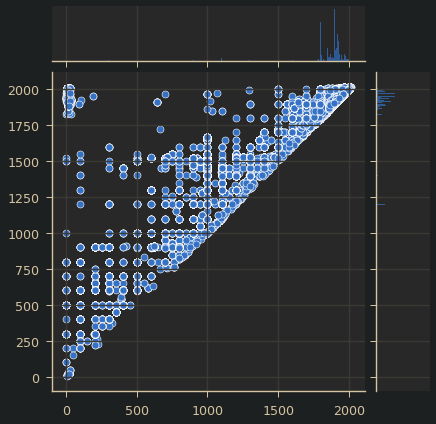

In [7]:
sns.jointplot(x=list(objs.BeginISODate), y=list(objs.EndISODate))

## Convert Dates to API-required Format

from: an integer representing the year to    
format: `YYYY-mm-dd`

In [8]:
def to_date_str(year_int):
    return dt.strptime(str(year_int).zfill(4),
                      "%Y").date()

objs["BeginISODate"] = objs.BeginISODate.apply(to_date_str)
objs["EndISODate"] = objs.EndISODate.apply(to_date_str)

# objs["start_date"] = objs.BeginISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))
# objs["end_date"] = objs.EndISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))

# 3. Classifications

In [9]:
cls_fields = ["ClassificationID","Classification", "AATCN", "SubClassification"] #, "SubClassification2"] -> always the same as AATCN when present
cls = pd.read_csv(tblpath + "Classifications.csv.gz")[cls_fields].set_index("ClassificationID")
# clsxr = pd.read_csv(tblpath + f"ClassificationXRefs_{k}.csv.gz")

In [10]:
# need to drop duplicates, otherwise those will duplicate the rows in objs
objs = objs.join(cls.drop_duplicates(keep="last"), how="left", on="ClassificationID")

# 4. Titles

TODO:

  - some objects in the `Objects` table have no entry in the `Titles` table (their `ObjectID` doesn't exist)  
    --> use `Title` from `Titles` only if exists and from `Objects` otherwise

In [11]:
title_fields = []
titles = pd.read_csv(tblpath + "ObjTitles.csv.gz").set_index("ObjectID")

/home/valentin/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
def merge_titles(obj_tbl):
    title_tbl = pd.read_csv(table_folder + "ObjTitles.csv.gz").set_index("ObjectID")
    
    common_keys = sorted(set(obj_tbl.index) & set(title_tbl.index))
    
    obj_tbl["vale_Title"] = obj_tbl.Title
    
    obj_tbl["vale_Title"].loc[common_keys] = title_tbl[common_keys]
    
    return obj_tbl

# 5. Locations?

### 5.1 Departments

In [13]:
dept_fields = ["DepartmentID", "Department"]

depts = pd.read_csv(tblpath + "Departments.csv.gz")
depts = depts.drop("GSRowVersion", axis="columns").drop_duplicates(keep="first")
depts = depts.set_index("DepartmentID")


# dpt_series = depts.Department[objs.DepartmentID]
# dpt_series.index = objs.index
# objs["Department"] = dpt_series

In [14]:
depts.index.unique(), objs.DepartmentID.unique()

(Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 26, 27, 34, 35, 36,
             37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 50, 52, 54, 55, 59, 61, 62,
             63, 96, 97, 98, 99],
            dtype='int64', name='DepartmentID'),
 array([3, 0, 7, 9, 27, 2, 6, 11, 5, 4, 1, 8, 10, '3', '2', '7', '4', '11',
        '6', '5', '9', '27', '1', 52, '0'], dtype=object))

In [15]:
def dept_id_to_int(id_col):
    for x in id_col:
        try:
            yield int(x)
        except ValueError:
            yield -10

dept_ids = list(dept_id_to_int(objs.DepartmentID))

objs["DepartmentID"] = dept_ids

In [16]:
objs = objs[objs.DepartmentID > -1]

In [17]:
objs.DepartmentID.value_counts()

3     88772
1     29363
7     21903
6     17198
2     16274
9     14130
52    12188
11     8379
4      6366
5      6105
10     5404
8      3769
27      979
0       657
Name: DepartmentID, dtype: int64

In [18]:
objs["Department"] = list(depts.loc[objs.DepartmentID].Department)

# Drop Objects by Criteria & Save

In [19]:
objs.shape, objs.drop_duplicates().shape

((231487, 19), (146694, 19))

In [20]:
objs = objs.drop_duplicates()

In [ ]:
# objs["ObjectID"] = objs.ObjectID.astype("int")

# objs = objs.set_index("ObjectID")

In [22]:
objs.index = objs.index.astype("int")

In [23]:
objs.to_csv("v0_2.csv.gz")

In [ ]:
objs.loc[1140716].Title

In [ ]:
objs

# Test Load

In [ ]:
loaded = pd.read_csv("v02.csv.gz").set_index("ObjectID")

In [ ]:
loaded.BeginISODate.apply(lambda s: dt.strptime(s, "%Y-%m-%d").date())

In [ ]:
s = loaded.BeginISODate.iloc[0]
str(dt.strptime(s,"%Y-%m-%d").date())

In [ ]:
loaded

# Thesaurus Stuff

In [ ]:
terms = pd.read_csv(tblpath + "TextEntries.csv.gz")

In [ ]:
terms

In [ ]:
terms.Term.value_counts()